# **Define a Baseline Model**

*The goal of this notebook is to create a baseline model that will serve as a reference for our future experiments. 
Before going into complex model architectures and extensive feature engineering, it's essential to create a foundational model. This baseline model will help us understand the performance of our system with minimal complexity.*

Importing necessary libraries

In [103]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import random

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score



from sklearn.ensemble import GradientBoostingClassifier


# from 2_preprocessing_pipeline import preprocess_text

## Apply the preprocesing pipeline on the dataset

Given the long execution time of the preprocessing pipeline, we will apply the pipeline one time then create a new csv with the preprocessed data

In [104]:
# Load the dataset
# df = pd.read_csv('data/APPLE_iPhone_SE.csv')

# Apply the preprocessing function to the 'Reviews' column
# df['Reviews'] = df['Reviews'].apply(preprocess_text)

# df.to_csv('data/APPLE_iPhone_SE_preprocessed.csv', index=False)

In [105]:
# Load the preprocessed dataset and the original dataset
df_unprocessed = pd.read_csv('data/APPLE_iPhone_SE.csv')
df = pd.read_csv('data/APPLE_iPhone_SE_preprocessed.csv')

After the preprocesseing, we have 6 empty reviews. Given the small quantity that this represents we will delete them :

In [106]:
df.dropna(subset=['Reviews'], inplace=True)

Comparison of a Review after and before the preprocessing

In [107]:
first_row_unprocessed = df_unprocessed["Reviews"].iloc[0]
first_row_processed = df["Reviews"].iloc[0]

print(first_row_unprocessed,"\n",first_row_processed)

Great camera for pics and videos Battery life is good so far with some setting turn of which i never use and when i use i turn those on and i use it in power saving mode all the time so a full day with light gaming of 1hr or more using camera for 1hr or more listening music in my car on youtube and Bluetooth on for couple of hours it gives me full day of battery varing from 4/5 to 6/7 hours sot per dayPerformance is top notch plays every game and every task with easeVery premium phone look...READ MORE 
 great camera pic videos battery life good far set turn never use use turn use power save mode time full day light game use camera listen music car youtube bluetooth couple hour give full day battery caring hour sot per dayperformance top notch play every game every task easevery premium phone look


In [108]:
df.head()

,Ratings,Comment,Reviews
0,5,Super!,great camera pic videos battery life good far ...
1,5,Must buy!,great device let tell pro superb build quality...
2,5,Great product,love old size ie inch type definitely go nothi...
3,5,Simply awesome,iphone se best phone ever get beautifully desi...
4,5,Classy product,second iphone iphone i 've long time android u...


## Define a class Model 

First, let's define X and y

In [109]:
# Split the data into training and testing sets
X = df["Reviews"] # text : the reviews preprocessed
y = df['Ratings'] #  outputs : Ratings


Now, let's create our Model class :

In [110]:
class Model:
    def __init__(self, X, y, model_architecture, vectorizer, random_seed=42, test_size=0.2) -> None:
        self.X = X
        self.y = y
        self.model_instance = model_architecture
        self.vectorizer = vectorizer
        self.random_seed = random_seed
        self.test_size = test_size

        self.pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', model_architecture)
        ]) 

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_seed)
    

    
    def fit(self):
        # fit self.pipeline to the training data
        self.pipeline.fit(self.X_train, self.y_train)

    def predict(self):
        return self.pipeline.predict(self.X_test)

    
    def predict_proba(self):
        return self.pipeline.predict_proba(self.X_test)
   
    
    def report(self, y_true, y_pred, class_labels):
        print(classification_report(y_true, y_pred, labels=class_labels, zero_division=0))

        confusion_matrix_kwargs = dict(
            text_auto=True,
            title="Confusion Matrix",
            width=1000,
            height=800,
            labels=dict(x="Predicted", y="True Label"),
            x=class_labels,
            y=class_labels,
            color_continuous_scale='Blues'
        )
        
        c_m = confusion_matrix(y_true, y_pred, labels=class_labels) 
        fig = px.imshow(c_m, **confusion_matrix_kwargs)
        fig.show()

## Gradient Boosting and Tfidf

In [111]:
# instantiate the Model class with text and labels (X and y), a Gradient Boosting model and a tfidf vectorizer
model_GB = Model(X, y, GradientBoostingClassifier(), TfidfVectorizer(), random_seed=42, test_size=0.2 )

# fit the model
model_GB.fit()

# predict and generate classification report
y_pred = model_GB.predict()
class_labels=[1, 2, 3, 4, 5]
model_GB.report(model.y_test, y_pred,class_labels)

              precision    recall  f1-score   support

           1       0.47      0.23      0.31        88
           2       0.31      0.09      0.14        44
           3       0.25      0.06      0.10        80
           4       0.36      0.08      0.13       363
           5       0.74      0.97      0.84      1367

    accuracy                           0.71      1942
   macro avg       0.43      0.29      0.30      1942
weighted avg       0.63      0.71      0.64      1942



## Result Analysis

The classification report and the confusion matrix shows us an overview of the model's performance over the different classes:

- Precision : It measures the accuracy of positive predictions. In our case, the precision is  low for classes 1, 2, 3, and 4 --> it means that when the model predicts these ratings, it is often incorrect. The precision is much higher for class 5 (1324 well predicted over ~1800) --> it means that when the model predicts this rating, it is often correct. We can notice a small confusion between 5 and 4 ratings which can be explained by the similarity between the meaning of this two classes.

- Recall: It measures the ability of the model to correctly identify instances of a class. The recall is low for classes 1, 2, 3, and 4, indicating that the model is not good at capturing these classes. The recall for class 5 is high --> it means that the model is good at identifying rating 5.

- F1-Score: It is the harmonic mean of precision and recall. The F1-score is low for classes 1, 2, 3, and 4 but higher for class 5.

- Accuracy : The accuracy of our model is 71% --> it means that the model correctly predicts the rating 71% of the time. But, this accuracy is influenced a lot by the dominance of class 5 (which has a high accuracy).

To conclude, the model performs well in predicting class 5, but it is weaker for the other classes. This imbalance is due to the class distribution. Indeed, class 5 has many samples compared to the other classes --> it explains the low precision and recall fot theses classes. 


## Investigate wrong predictions

In [112]:
test_data = pd.concat((model.X_test, model.y_test), axis=1)
test_data["pred"] = y_pred
# using np.where, create a variable equal to one when the encoded sentiment and model prediction match
test_data["correct_prediction"] = np.where(test_data["Ratings"]==test_data["pred"], 1, 0) 
test_data

,Reviews,Ratings,pred,correct_prediction
4363,good product,4,5,0
1806,good,4,5,0
5461,good phone price camera perform great good lig...,4,5,0
6800,nice,5,5,1
6588,good,3,5,0
...,...,...,...,...
3283,best,5,5,1
6112,expect,4,5,0
3266,excellent product best part size late hardware,5,5,1
3465,good order variant include charger earbuds,3,5,0


In [113]:
px.histogram(test_data, x="pred", 
             color="correct_prediction", 
             barmode="stack", 
            )

## Let's execute the following cell a bunch of times to assess the quality of the model

In [114]:
num_samples = 5

# Randomly select num_samples row indices
random_indices = random.sample(test_data.index.tolist(), num_samples)

for index in random_indices:
    sample = test_data.loc[index]
    print(f"Preprocessed Review: {sample['Reviews']}")
    print(f"Original Review: {df_unprocessed['Reviews'].iloc[index]}")
    print(f"True label: {sample['Ratings']}")
    print(f"Prediction: {sample['pred']}\n")



Preprocessed Review: good phone fast delivery flipkartthank flippant
Original Review: Good phone and fast delivery by Flipkart.Thank you FlipkartREAD MORE
True label: 4
Prediction: 5

Preprocessed Review: superb product well android
Original Review: Superb product. Better than androidREAD MORE
True label: 5
Prediction: 5

Preprocessed Review: overall give satisfied displayprocessor durability handy disappointed withbattery charger mobile
Original Review: Overall I give 4out of 5 Satisfied with display,processor, durability Handy  Disappointed withBattery Charger with mobileREAD MORE
True label: 4
Prediction: 5

Preprocessed Review: best value money get iphone
Original Review: Best value for money!! I got this iphone just 26000READ MORE
True label: 5
Prediction: 5

Preprocessed Review: nice handy mobile
Original Review: Very nice and handy mobile.READ MORE
True label: 4
Prediction: 5



We can see that the quality of the model can be lowerd by reviews that are sometimes too short or the similarity between two reviews having only 1 rating point difference (for example : Preprocessed Review: nice handy mobile / Original Review: Very nice and handy mobile.READ MORE/ True label: 4 /Prediction: 5)

## Check the probability distribution of predictions

In [115]:
probas = pd.DataFrame(model.predict_proba())
probas.columns = class_labels
probas.head()

,1,2,3,4,5
0,0.007712,0.002084,0.025147,0.238748,0.726309
1,0.002376,0.001706,0.054227,0.253607,0.688084
2,0.004764,0.005721,0.048724,0.211531,0.729260
3,0.002460,0.001452,0.019242,0.156297,0.820549
4,0.002376,0.001706,0.054227,0.253607,0.688084


In [116]:
probas.describe()

,1,2,3,4,5
count,1942.000000,1942.000000,1942.000000,1942.000000,1942.000000
mean,0.046151,0.018983,0.055536,0.169993,0.709337
std,0.094929,0.029719,0.069450,0.104262,0.211709
min,0.000266,0.000238,0.001250,0.008748,0.018540
25%,0.004560,0.002890,0.014121,0.092230,0.620865
50%,0.012533,0.008227,0.031797,0.148918,0.767694
75%,0.037400,0.020839,0.061069,0.236636,0.869248
max,0.813182,0.228682,0.477407,0.783461,0.986497


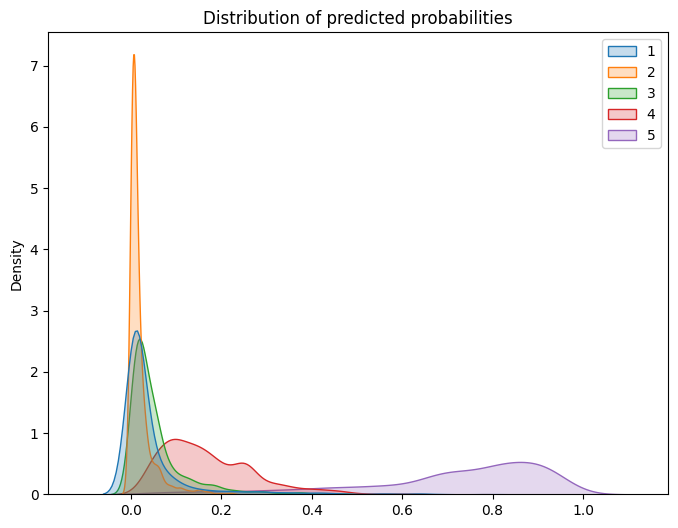

In [117]:
plt.figure(figsize=(8,6))
sns.kdeplot(data=probas, fill=True, )
plt.title("Distribution of predicted probabilities")
plt.show()

The probability distribution confirms us that the model is not confident with its predictions for certain classes. Indeed, there are low probabilities for 1,2,3 and 4 ratings (from ~2% to ~16%). We can notice that the model is a little more confident for the predictions of 4 ratings. The model have a high predicted probability for 5 ratings (~70%) : it relates with the performance seen in the previous confusion matrices and classification report. 

## **Improve the Baseline model**

The imbalanced nature of the dataset is the principal reason of our current model limitation. We will need to improve this baseline model by using different techniques to improve performances. 